A notebook to study the imaging systematics in eBOSS v6 QSO

In [1]:
import sys
sys.path.append('/Users/rezaie/github/LSSutils')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import f_regression
from LSSutils.catalogs.combinefits import EBOSSCAT
from LSSutils.catalogs.datarelease import cols_eboss_v6_qso_simp as attrs_names

camb is not installed!


In [61]:
def F_test(ZCUT):
    sysmaps = pd.read_hdf('/Volumes/TimeMachine/data/eboss/sysmaps/SDSS_HI_imageprop_nside256.h5')
    qso = EBOSSCAT(['/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits'])
    qso.apply_zcut(zcuts=ZCUT)
    qso.project2hp(nside=256)

    ran = EBOSSCAT(['/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6.ran.fits'], 
                   weights=['weight_noz', 'weight_cp', 'weight_systot'])
    ran.apply_zcut(zcuts=ZCUT)
    ran.project2hp(nside=256)
    
    x    = sysmaps.values
    m    = ran.galm != 0.0
    y    = np.zeros_like(qso.galm)*np.nan
    y[m] = qso.galm[m] / (ran.galm[m] * (qso.galm[m].sum()/ran.galm[m].sum()))


    mydata = pd.DataFrame(np.column_stack([x, y]),
                          columns=attrs_names + ['nqso'])
    mydata.dropna(inplace=True)
    # sns.heatmap(mydata.corr(), cmap=plt.cm.seismic, center=0.0, cbar_kws={'label':'PCC'})
    #
    #  scale the imaging attrs.
    #
    X = mydata.values[:, :-1]
    Y = mydata.values[:, 17]
    X = (X - np.mean(X, axis=0))/np.std(X, axis=0, ddof=1)
    results = f_regression(X, Y, center=True)
    return results
    #plt.plot(results[1], attrs_names, '.')
    #plt.grid()

In [62]:
sample1 = F_test([0.8, 1.1])

len of gal cats 1
num of gal obj 216893
going to apply z-cuts : [0.8, 1.1]
num of gal obj after cut 36796
projecting into a healpix map with nside of 256
len of gal cats 1
num of gal obj 5565871
going to apply z-cuts : [0.8, 1.1]
num of gal obj after cut 944489
projecting into a healpix map with nside of 256


In [63]:
sample2 = F_test([1.5, 2.2])

len of gal cats 1
num of gal obj 216893
going to apply z-cuts : [1.5, 2.2]
num of gal obj after cut 109942
projecting into a healpix map with nside of 256
len of gal cats 1
num of gal obj 5565871
going to apply z-cuts : [1.5, 2.2]
num of gal obj after cut 2820965
projecting into a healpix map with nside of 256


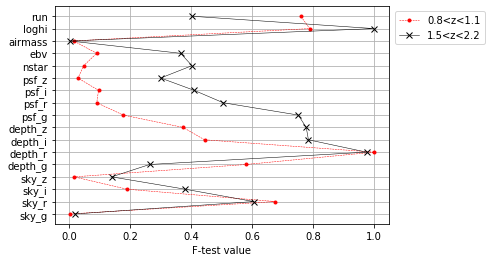

In [64]:
plt.plot(sample1[0]/np.max(sample1[0]), attrs_names, '.', ls='--', color='r', label='0.8<z<1.1', lw=0.5)
plt.plot(sample2[0]/np.max(sample2[0]), attrs_names, 'x', ls='-', color='k', label='1.5<z<2.2', lw=0.5)
plt.legend(bbox_to_anchor=(1.3, 1.))
plt.xlabel('F-test value')
plt.grid()

In [33]:
from scipy.stats import f

In [42]:
f.sf(1.0, 1, 100)

0.3197241557841201

In [39]:
import sklearn


In [40]:
sklearn.__file__

'/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/sklearn/__init__.py'

In [54]:
x = np.random.normal(size=100)
y = np.random.normal(size=100)*0.1

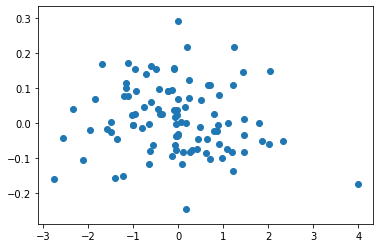

In [55]:
plt.scatter(x, y)

In [56]:
np.corrcoef(x, y)

array([[ 1.        , -0.09964358],
       [-0.09964358,  1.        ]])

In [57]:
-0.09964358**2 / (1-0.09964358**2) * (x.size-1)

-0.9928129443744484

In [58]:
f.sf(0.9928129443744484, 1, x.size-1)

0.3214850253676753